In [1]:
import numpy as np
import reddemcee

import matplotlib.pyplot as pl

In [2]:
np.random.seed(1234)

In [3]:
def logl(x, *args, **kwargs):
    # x shape: (ntemps, nwalkers, ndim)
    return -0.5 * np.sum(x ** 2, axis=-1)  # Returns shape: (ntemps, nwalkers)

def logp(x, *args, **kwargs):
    # x shape: (ntemps, nwalkers, ndim)
    lp = 0.
    for p in x:
        if ((-100 < p) & (p < 100)).all():
            lp += 0
        else:
            return -np.inf
    return lp


egg_beta = 5
ndim_ = 2
lim_ = (4*np.pi/2)**ndim_
limits_ = [[-lim_, lim_] for _ in range(ndim_)]

def loglike_egg(theta):
    #logl = (2 + np.cos(theta[0] / 2) * np.cos(theta[1] / 2))**egg_beta
    logl = (2 + np.prod(np.cos(theta/4)))**egg_beta
    return logl


def logprior_egg(theta):
    lp = 0.
    for i in range(ndim_):
        if  theta[i] <= limits_[i][0] or limits_[i][1] <= theta[i]:
            return -np.inf
    return ndim_*np.log(1 / (limits_[0][1] - limits_[0][0]))


In [4]:
setup = [10, 100, 1000, 2]
ntemps, nwalkers, nsweeps, nsteps = setup
p0 = np.random.uniform(-np.pi, np.pi, [ntemps, nwalkers, ndim_])
my_betas = np.geomspace(1, 0.001, ntemps)
my_betas = list(np.linspace(1, 0.000, ntemps))

In [5]:
sampler = reddemcee.PTSampler(nwalkers,
                    ndim_,
                    loglike_egg,
                    logprior_egg,
                    betas=my_betas,
                    smd_history=True,
                    tsw_history=True,
                    )

sampler._swap_move.D_ = np.diff(limits_).flatten()
sampler.select_adjustment(0)

In [6]:
for results in sampler.sample(p0, nsweeps=nsweeps, nsteps=nsteps, progress=True):
    pass

100%|██████████| 20000/20000 [00:20<00:00, 989.63it/s] 


In [7]:
sampler.thermodynamic_integration_classic()

(235.86569032877958, 1.0606841526795847)

In [10]:
sampler.get_chain(flat=True)[:, -1]

array([[ 12.86941129,  12.42929025],
       [  0.51027389,  25.39649262],
       [-37.89270119, -37.73080977],
       [  1.03596974,  25.39382987],
       [  0.82720808,   0.0883858 ],
       [-12.00127949,  12.7473743 ],
       [-13.90252773, -37.25231499],
       [ 26.1494684 ,  23.27772188],
       [-26.26411227, -24.83353649],
       [-31.31558033,   2.40698903]])

In [11]:
sampler.thermodynamic_integration()

(236.16820073493005,
 0.302511085446373,
 0.30251040615047486,
 0.0006410839395439036)

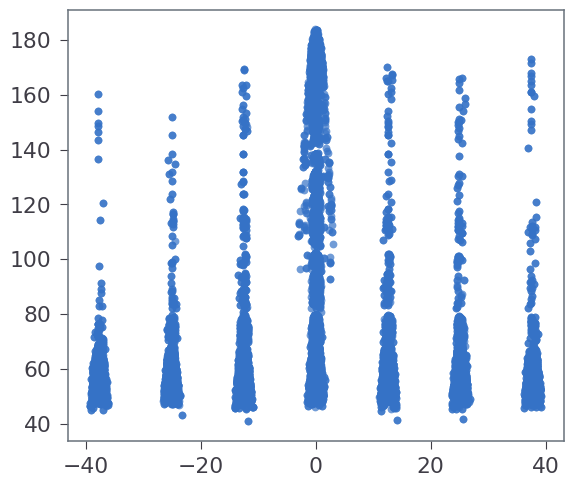

In [12]:
# Single Dim Posterior
if True:
    temp = 2
    coord0 = sampler.backend[temp].get_chain(flat=True)[:, 0]
    logprob0 = sampler.backend[temp].get_log_prob(flat=True)
    pl.plot(coord0, logprob0, 'bo', alpha=0.7)

In [13]:
# Single Walker Plot
if False:
    pl.figure(figsize=(12, 2))
    pl.plot(sampler.backend[0].get_chain()[:, :, 0], "ok", lw=0.5)
    #pl.xlim(0, len(sampler_adapt.get_chain()))
    #pl.ylim(-5.5, 5.5)
    pl.title(f"move: swap", fontsize=14)
    pl.xlabel("step number")
    pl.ylabel("x");

In [14]:
def running(arr, window_size=10):
    """Calculate running average of the last n values."""
    averages = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        start_idx = max(0, i - window_size + 1)  # Start of the window (avoid negative index)
        averages[i] = np.mean(arr[start_idx:i + 1], axis=0)  # Average of the last `window_size` points
    return averages

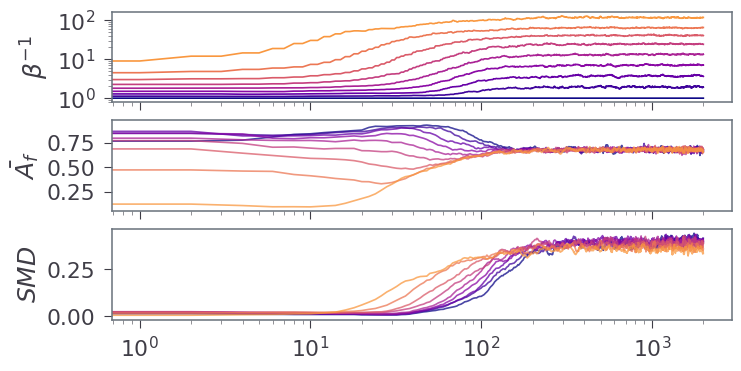

In [15]:
# Triple Temp Plot

if True:
    import matplotlib
    cmap = matplotlib.colormaps['plasma']
    colors = cmap(np.linspace(0, 0.85, setup[0]))
    x0 = np.arange(setup[2]) * setup[3]
    window_size = 10

    if True:
        TITLE = r'$Temperatures$'
        FIGSIZE = (8, 4)
        XLABEL = r'$T$'

    fig, axes = pl.subplots(3, 1, figsize=FIGSIZE, sharex=True)

    for t in range(ntemps-1):
        # PLOT BETAS
        b = sampler.backend[t]
        axes[0].plot(1/b.beta_history, c=colors[t])

        # PLOT TS_ACCEPTANCE
        y0 = running(sampler.backend.tsw_history[:, t], window_size)
        axes[1].plot(x0, y0, alpha=0.75, color=colors[t])

        # PLOT SWAP MEAN DISTANCE
        y_smd = running(sampler.backend.smd_history[:, t], window_size)
        axes[2].plot(x0, y_smd, alpha=0.75, color=colors[t])


    axes[0].set_ylabel(r"$\beta^{-1}$")
    axes[1].set_ylabel(r"$\bar{A_{f}}$")
    axes[2].set_ylabel(r"$SMD$")

    axes[0].set_xscale('log')
    axes[0].set_yscale('log')

    #axes[1].set_xscale('log')